In [2]:
import struct
import pandas as pd
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)

In [4]:
log = 'flight_logs/flight_day_2/flight_008_sensor_offset.txt'
#log = '../flight_day_2/test_flight_x.txt'
#log = 'flight_logs/h_flight_2.log'

In [5]:
log_b = None
with open(log, 'r') as f:
    log_str = f.read()

log_str_formatted = log_str.replace('\r\n', ' ')
log_str_formatted = log_str_formatted.replace('\n', ' ')
log_str_formatted = log_str_formatted.replace('  ', ' ')
log_str_formatted = log_str_formatted.strip()

In [6]:
# with open('test_log', 'w') as log_file:
#     log_file.write(log_str_formatted)

In [7]:
#log_b[26400:26500]

In [8]:
log_b = bytes.fromhex(log_str_formatted)

In [9]:
print(log_b[:20])

b'\n\x00\x00\x00\xa9a\x00\x00\x00\x01\x00\x00\x01\x00\xa5\xa5\t\x00\x00\x00'


In [10]:
imu = []
baro = []
flight_info = []
flight_state = []
covariance_info = []
sensor_info = []

In [11]:
i = 0
last_ts = 0
while i < len(log_b):
    t = struct.unpack('<L', log_b[i:i+4])[0]
    i += 4
    if t in [1, 2, 3]:
        ts, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z = struct.unpack('<Lhhhhhh', log_b[i: i+16])
        #print(f"{ts} IMU {t-1}: Gx: {gyro_x}, Gy: {gyro_y}, Gz: {gyro_z}, Ax: {acc_x}, Ay: {acc_y}, Az: {acc_z}")
        imu.append({'ts': ts,
                    'id': f'IMU{t - 1}',
                    'Gx': gyro_x,
                    'Gy': gyro_y,
                    'Gz': gyro_z,
                    'Ax': acc_x,
                    'Ay': acc_y,
                    'Az': acc_z})
        #print(imu_data)
        i += 4 + 6 + 6 #ts + 6 x int16
    elif t in [4, 5, 6]:
        ts, pressure, temperature = struct.unpack('<LLL', log_b[i: i+12])
        #print(f"{ts} BARO {t-4}: P: {pressure}, T: {temperature}")
        baro.append({'ts': ts,
                     'id': f'BARO{t - 4}',
                     'T': temperature,
                     'P': pressure})
        #print(baro_data)
        i += 4 + 4 + 4
    elif t == 7:
        ts, height, velocity, acceleration, altitude_agl = struct.unpack('<Lffff', log_b[i: i+20])
        #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
        flight_info.append({'ts': ts,
                            'height': height,
                            'velocity': velocity,
                            'acceleration': acceleration,
                            'altitude_agl': altitude_agl})
        #print(flight_info_data)
        i += 4 + 4 + 4 + 4 + 4
    elif t == 8:
        #print("FLIGHT_STATE")
        #ts, state = struct.unpack('<LB', log_b[i: i+5])
        ts, state = struct.unpack('<LL', log_b[i: i+8])
        flight_state.append({'ts': ts, 'state': state})
        #print(f"{ts} FLIGHT STATE: State: {state}")
        i += 4 + 4
    elif t == 9:
        ts, height_cov, velocity_cov = struct.unpack('<Lff', log_b[i: i+12])
        #print(f"{ts} COVARIANCE_INFO: Height cov: {height_cov}, Velocity cov: {velocity_cov}")
        covariance_info.append({'ts': ts,
                                'height_cov': height_cov,
                                'velocity_cov': velocity_cov})
        #print(flight_info_data)
        i += 4 + 4 + 4
    elif t == 10:
        #print(f"Sensor info found at {i}")
        ts, imu_0, imu_1, imu_2, baro_0, baro_1, baro_2 = struct.unpack('<LBBBBBB', log_b[i: i+10])
        sensor_info.append({'ts': ts,
                                'imu_0': imu_0,
                                'imu_1': imu_1,
                                'imu_2': imu_2,
                                'baro_0': baro_0, 'baro_1': baro_1, 'baro_2': baro_2})
        i += 4 + 6 + 2 # +2 is because of the padding
    else:
        print(f"ERROR at {i}")
        break
    last_ts = ts

ERROR at 445084


In [12]:
imu_df = pd.DataFrame(imu)

<AxesSubplot:xlabel='ts', ylabel='Ax'>

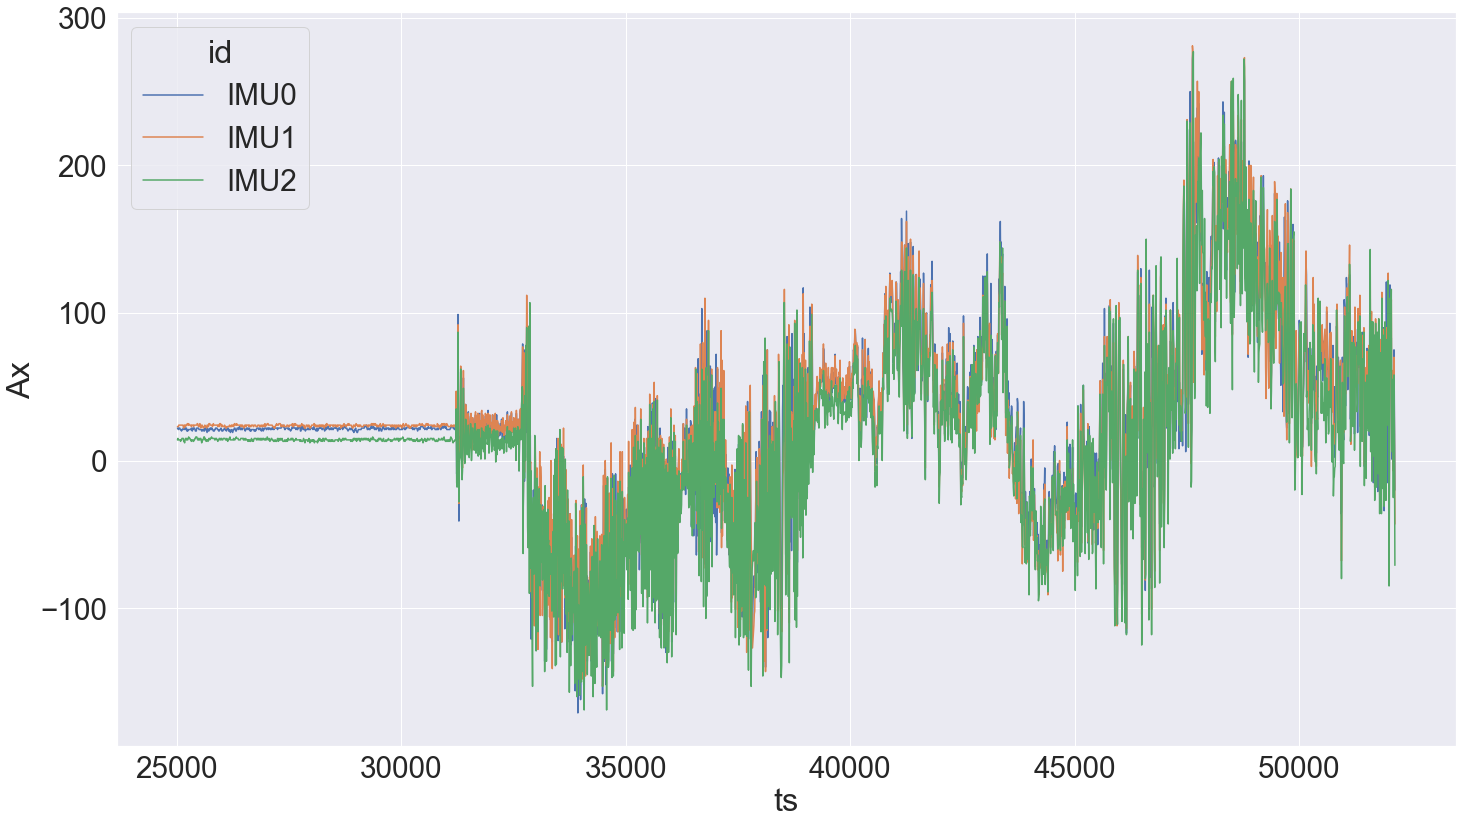

In [13]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Ax', hue = 'id')
#ax.set_ylim(-10, 6000)
#ax.set_xlim(45000, 48000)

<AxesSubplot:xlabel='ts', ylabel='Ay'>

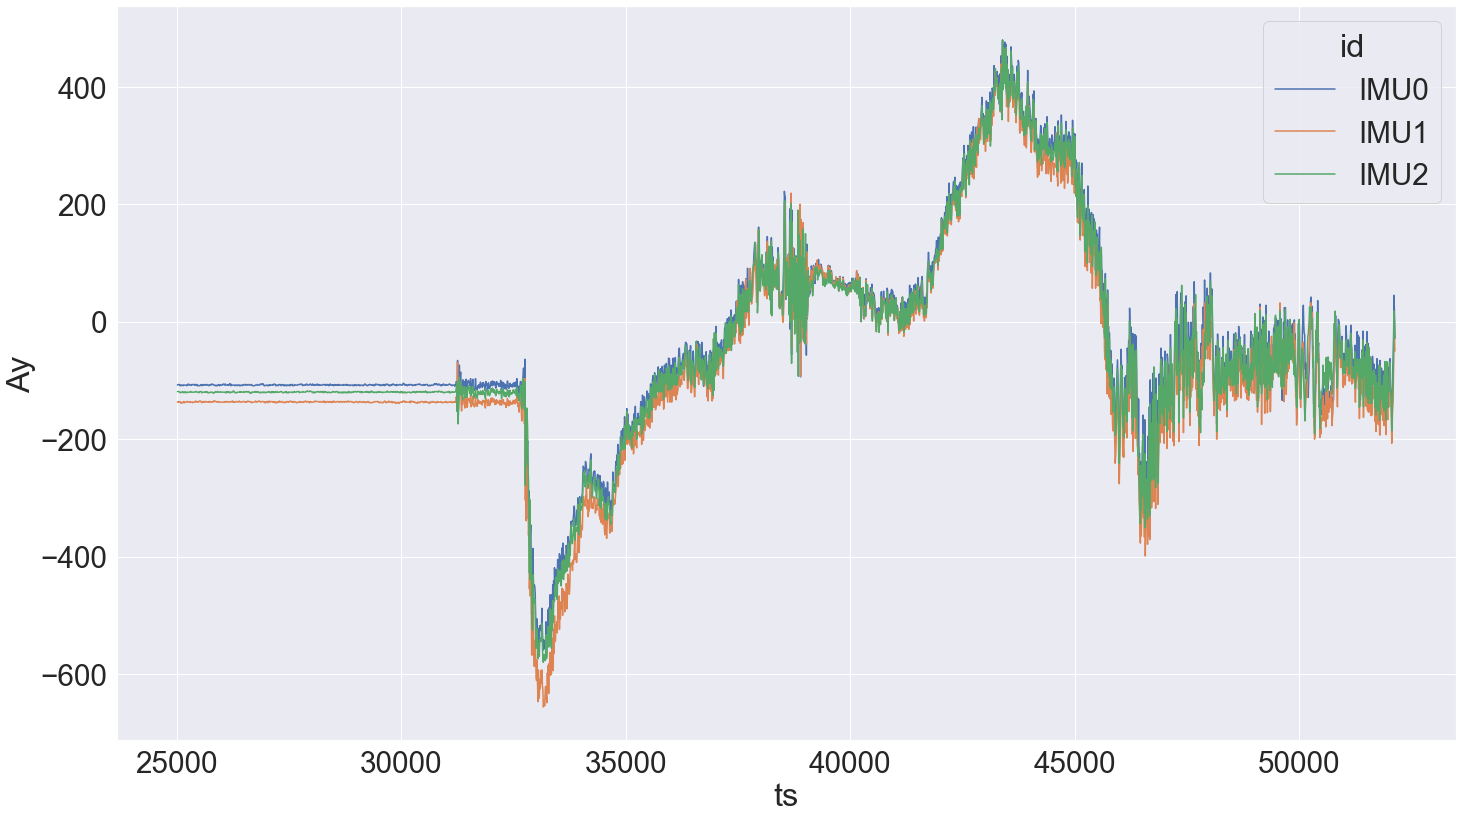

In [14]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Ay', hue = 'id')

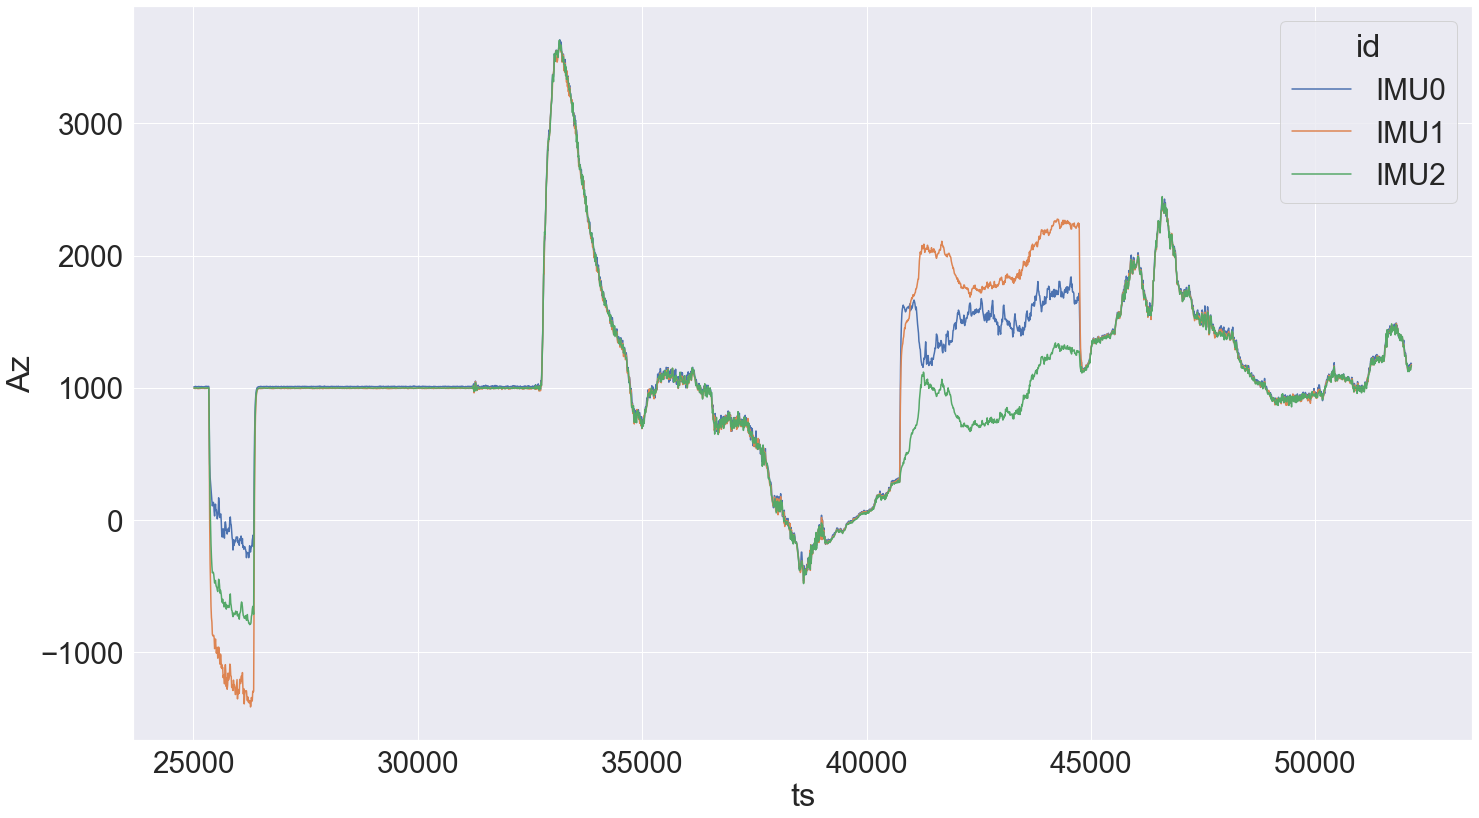

In [15]:

ax = sns.lineplot(data = imu_df, x = 'ts', y = 'Az', hue = 'id')
#ax.set_xlim(25240, 25500)

<AxesSubplot:xlabel='ts', ylabel='Gx'>

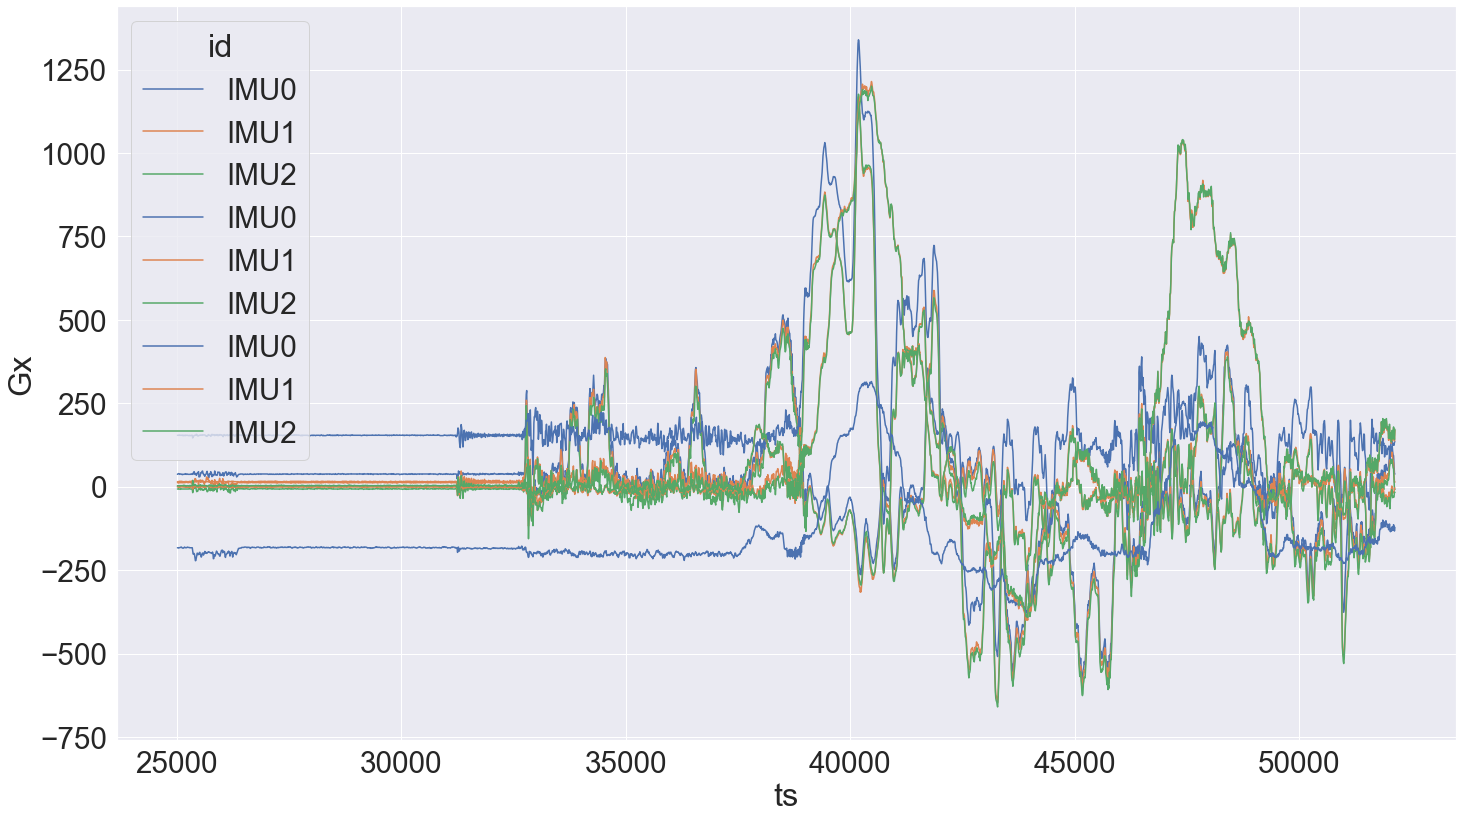

In [16]:
sns.lineplot(data = imu_df, x = 'ts', y = 'Gx', hue = 'id')
sns.lineplot(data = imu_df, x = 'ts', y = 'Gy', hue = 'id')
sns.lineplot(data = imu_df, x = 'ts', y = 'Gz', hue = 'id')

In [17]:
flight_state

[{'ts': 25339, 'state': 2},
 {'ts': 32919, 'state': 3},
 {'ts': 37669, 'state': 5},
 {'ts': 40729, 'state': 9},
 {'ts': 43739, 'state': 10}]

In [18]:
imu_df

,ts,id,Gx,Gy,Gz,Ax,Ay,Az
0,25017,IMU0,37,154,-183,22,-108,1007
1,25017,IMU1,12,15,-1,23,-137,997
2,25017,IMU2,-7,1,3,14,-119,998
3,25027,IMU0,38,154,-183,22,-107,1007
4,25027,IMU1,12,15,-1,23,-137,996
...,...,...,...,...,...,...,...,...
8134,52127,IMU1,13,-4,137,16,-23,1167
8135,52127,IMU2,-9,-16,141,8,0,1149
8136,52137,IMU0,38,135,-122,-20,-29,1182
8137,52137,IMU1,14,-4,169,-43,-50,1175


In [19]:
flight_info_df = pd.DataFrame(flight_info)

In [20]:
flight_info_df

,ts,height,velocity,acceleration,altitude_agl
0,25001,244.231003,-55.729000,4.731758,159.880585
1,25011,244.339005,-55.856998,4.741338,165.372559
2,25021,244.445007,-55.984001,4.731758,161.569778
3,25031,244.533005,-54.101002,4.722178,161.329254
4,25041,244.638000,-54.226002,4.712598,157.861435
...,...,...,...,...,...
2709,52091,-5.105000,-7.658000,2.750240,-122.854759
2710,52101,-5.029000,-7.663000,2.697920,-124.607925
2711,52111,-6.949000,-7.664000,2.671760,-124.607925
2712,52121,-6.878000,-7.671000,2.822180,-124.607925


In [21]:
covariance_df = pd.DataFrame(covariance_info)

In [22]:
#lower_bound = flight_info_df.height + 3*(covariance_df.height_cov)**0.5]
flight_info_df['lower_bound'] = flight_info_df.height + 3*(covariance_df.height_cov)**0.5
flight_info_df['upper_bound'] = flight_info_df.height - 3*(covariance_df.height_cov)**0.5

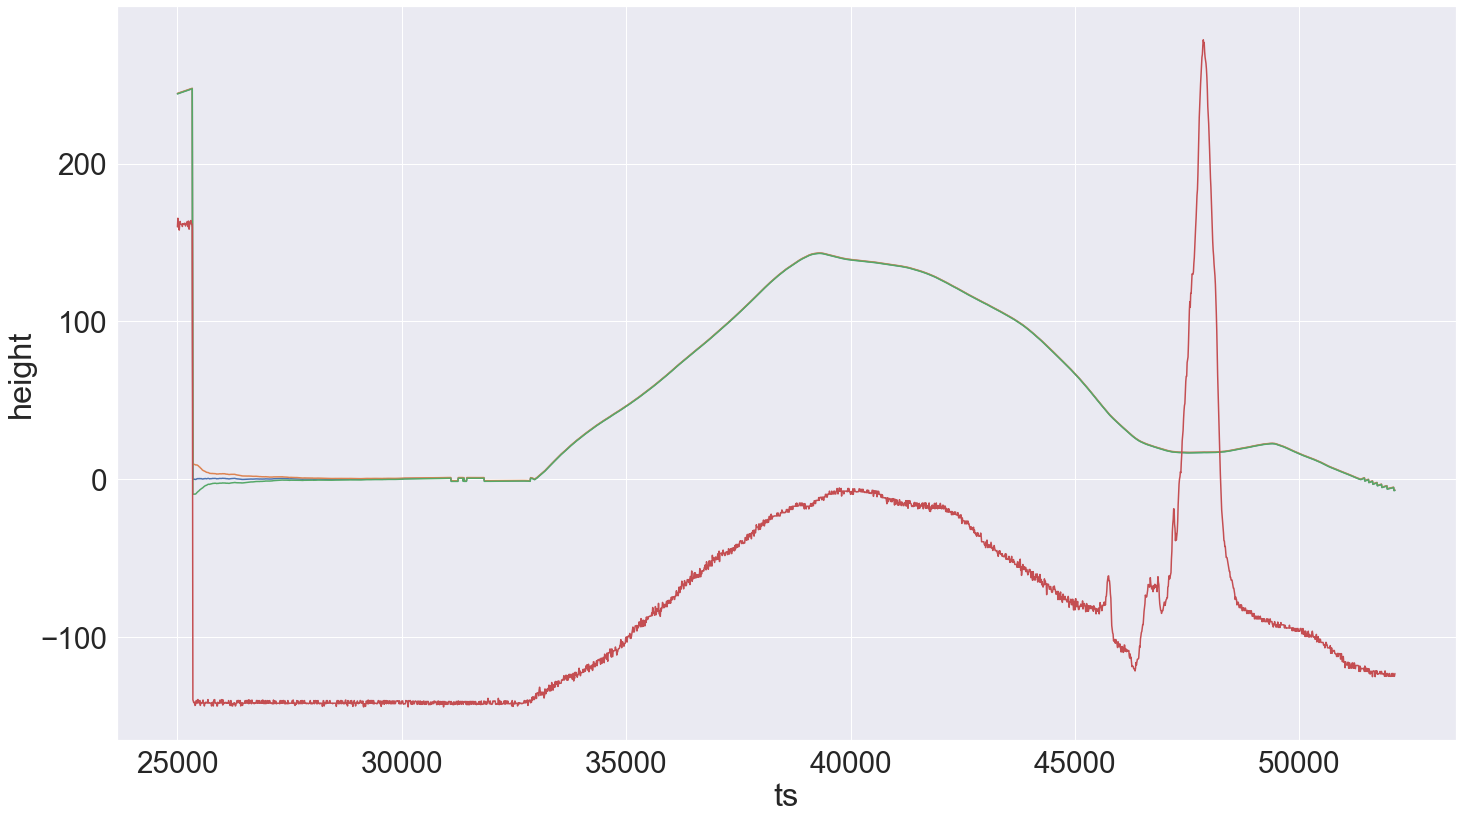

In [23]:
sns.lineplot(data = flight_info_df, x = 'ts', y = 'height')
sns.lineplot(data = flight_info_df, x = 'ts', y = 'lower_bound')
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'upper_bound')
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'altitude_agl')
#ax.set_ylim(-10, 20)
#ax.set_xlim(30000,60000)

(40000.0, 44000.0)

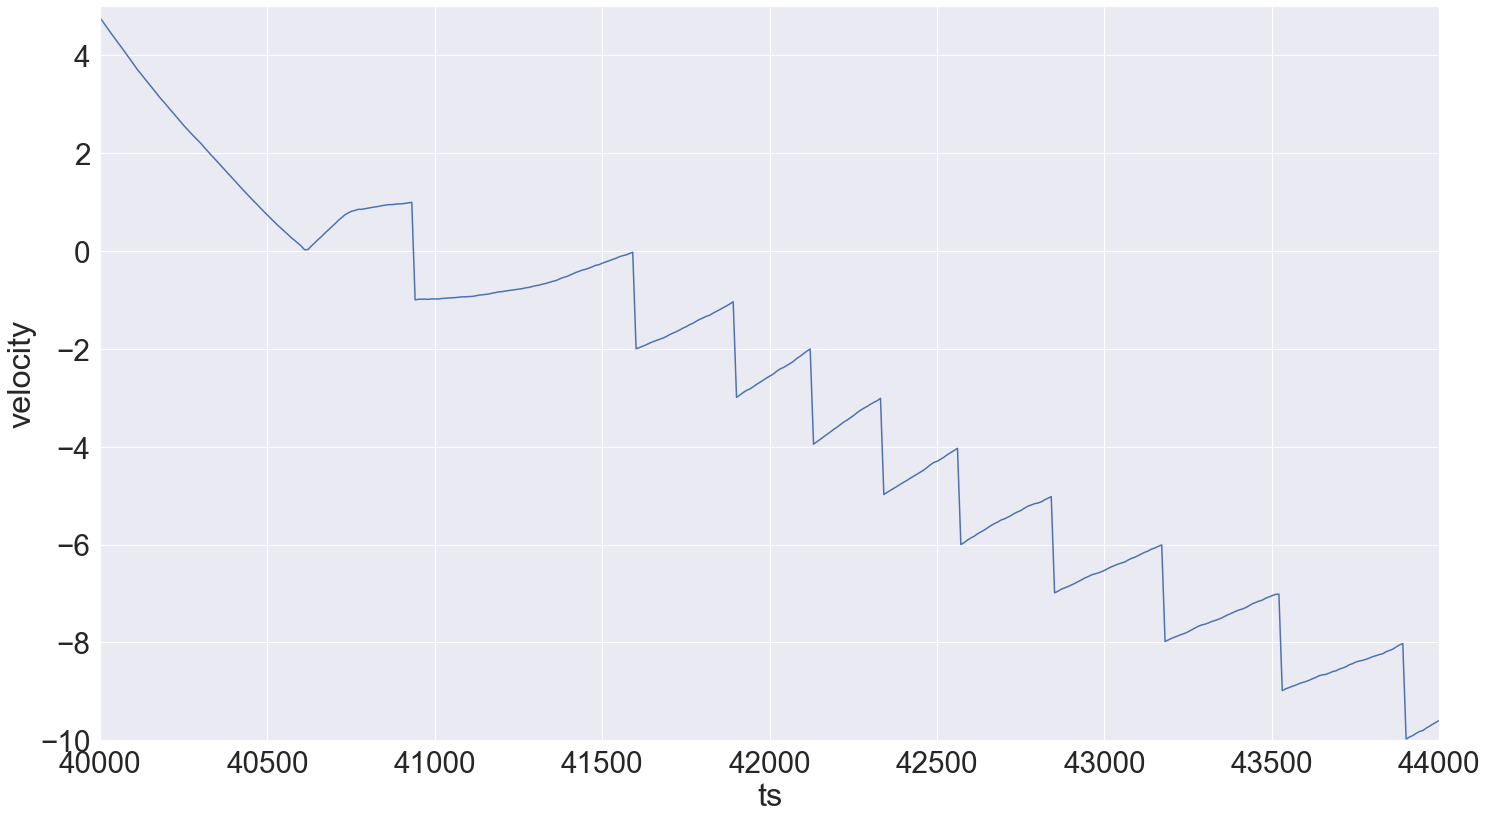

In [28]:
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'velocity')
ax.set_ylim(-10, 5)
ax.set_xlim(40000, 44000)

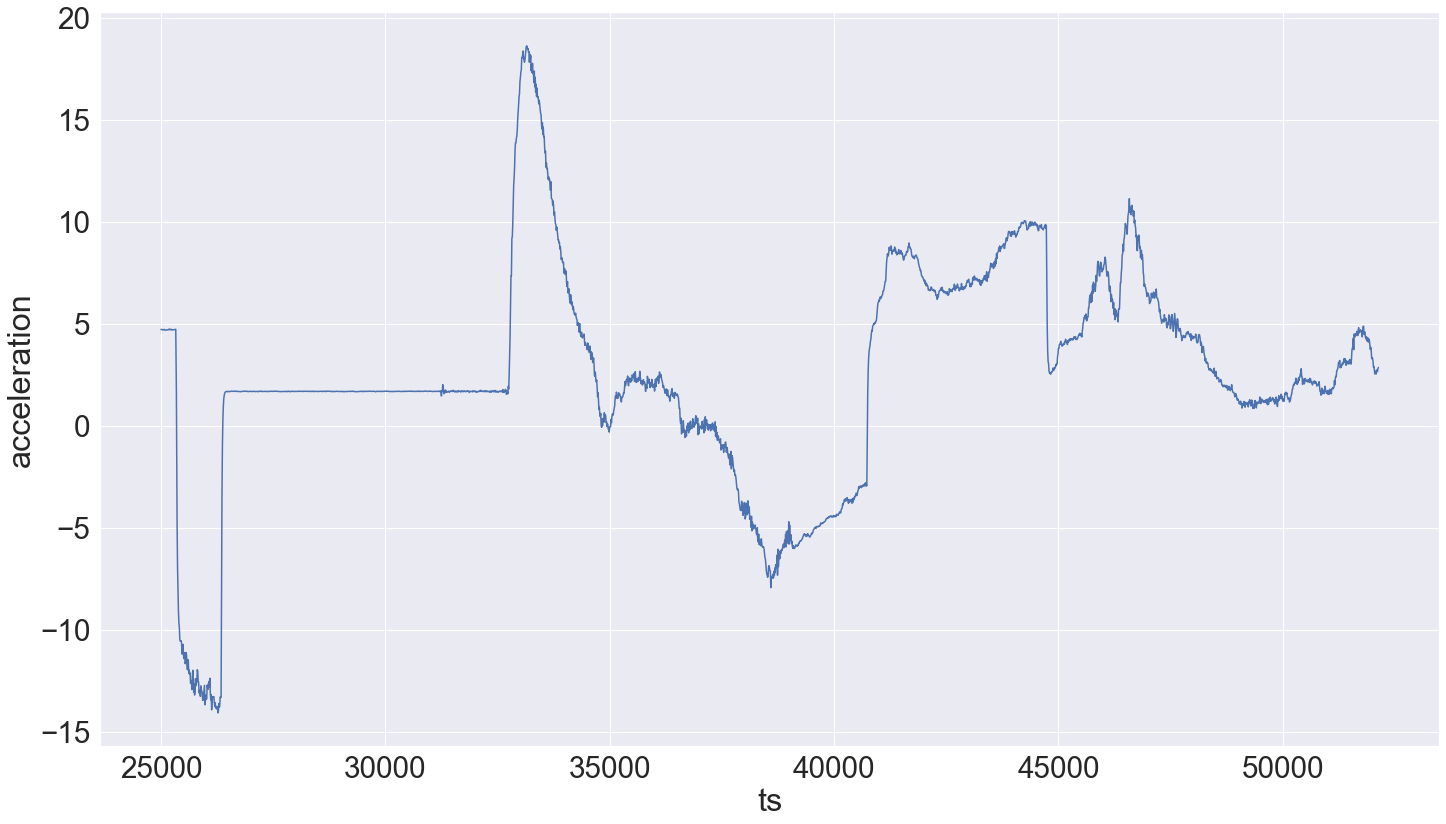

In [25]:
ax = sns.lineplot(data = flight_info_df, x = 'ts', y = 'acceleration')
#ax.set_ylim(-5)
#ax.set_xlim(38000)

In [25]:
baro_df = pd.DataFrame(baro[:-1])

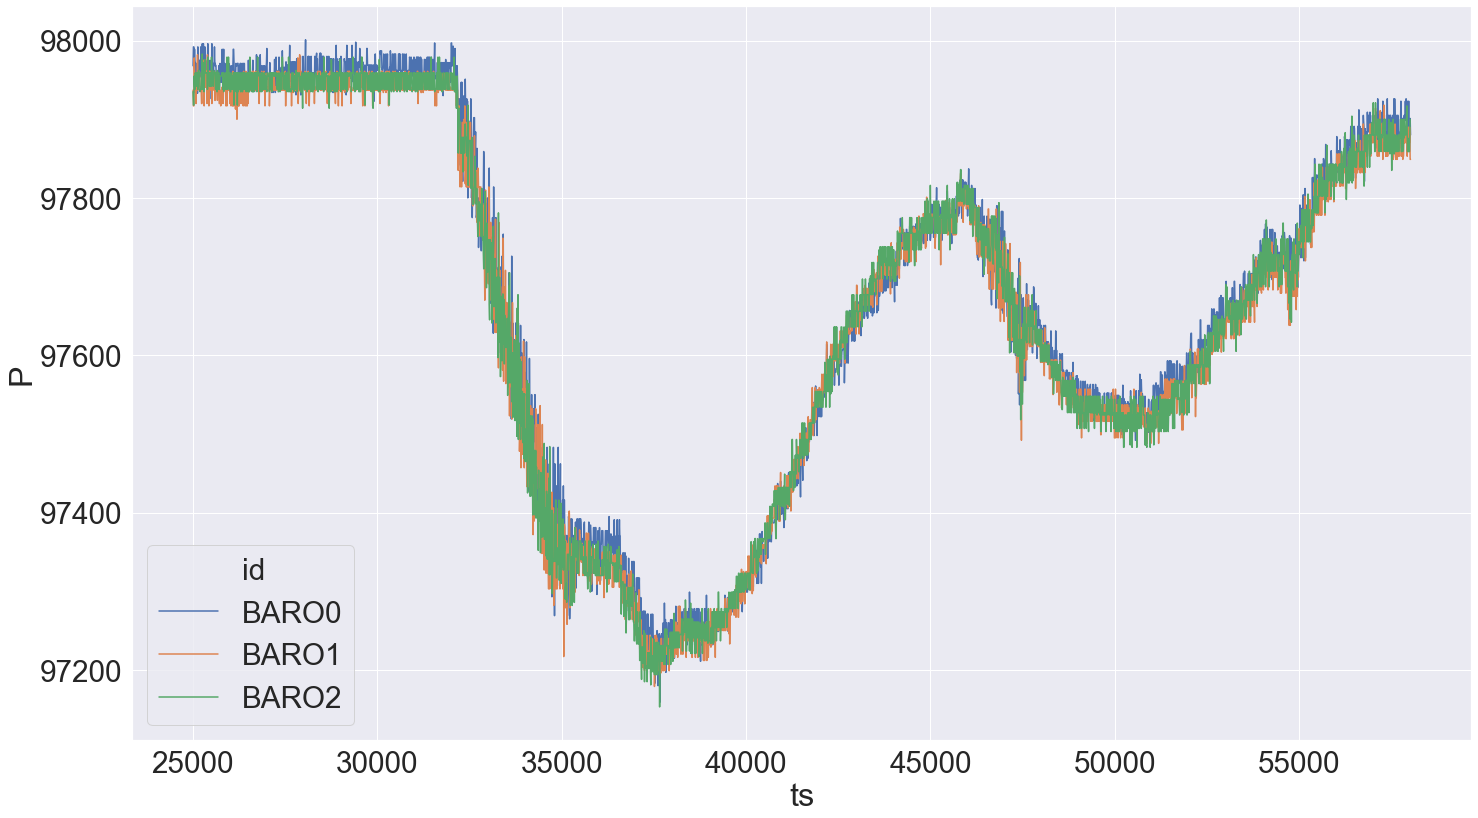

In [26]:
ax = sns.lineplot(data = baro_df, x = 'ts', y = 'P', hue='id')

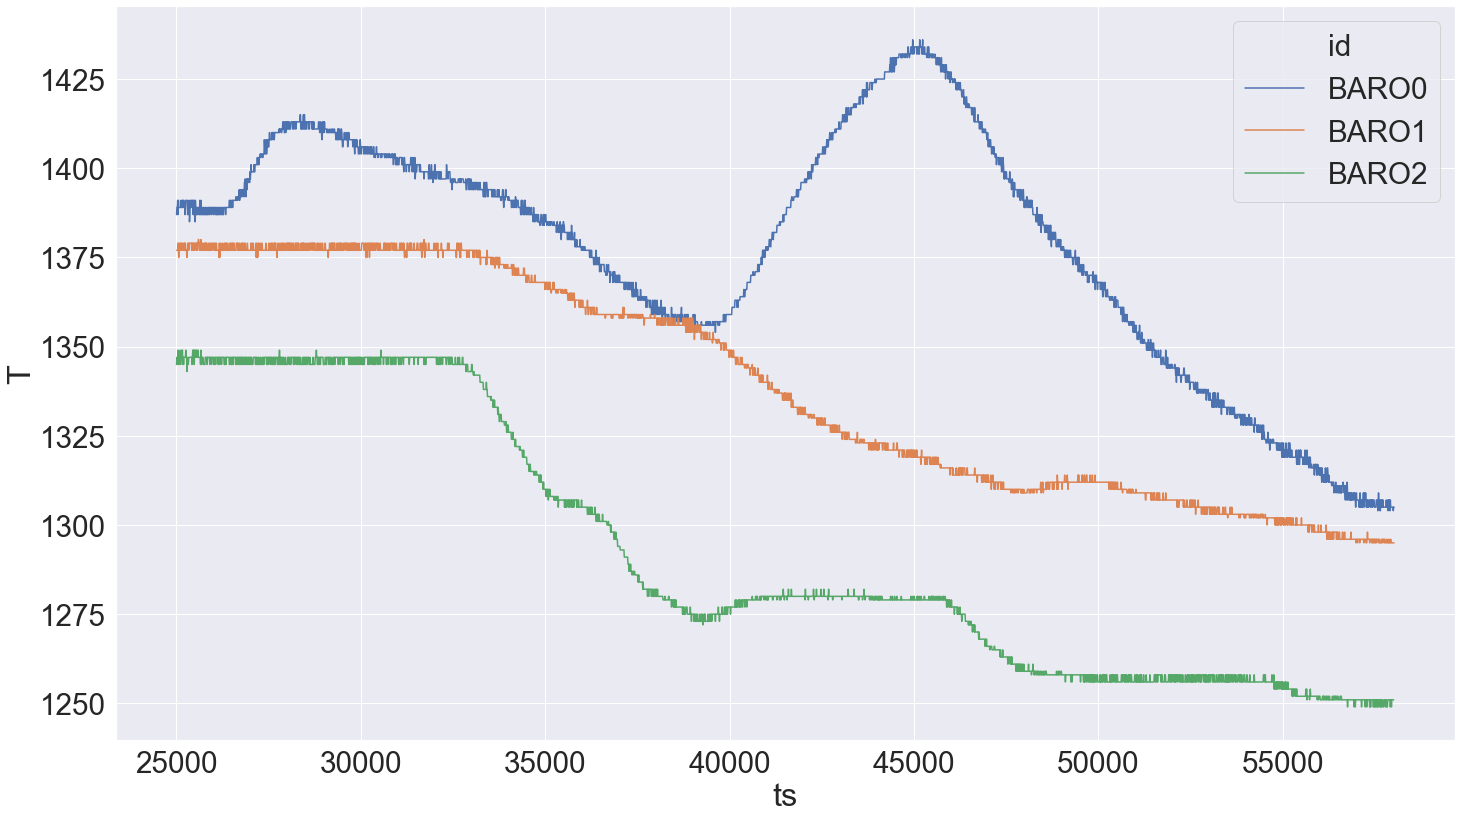

In [27]:
ax = sns.lineplot(data = baro_df, x = 'ts', y = 'T', hue='id')

In [28]:
baro_df

,ts,id,T,P
0,25006,BARO0,1387,97968
1,25006,BARO1,1377,97937
2,25006,BARO2,1345,97935
3,25016,BARO0,1389,97992
4,25016,BARO1,1377,97917
...,...,...,...,...
9900,58006,BARO0,1305,97901
9901,58006,BARO1,1295,97849
9902,58006,BARO2,1251,97900
9903,58016,BARO0,1305,97880


In [29]:
sensor_info_df = pd.DataFrame(sensor_info)

In [30]:
sensor_info_df

,ts,imu_0,imu_1,imu_2,baro_0,baro_1,baro_2
0,25007,0,0,0,0,0,0
1,25017,0,0,0,0,0,0
2,25027,0,0,0,0,0,0
3,25037,0,0,0,0,0,0
4,25047,0,0,0,0,0,0
...,...,...,...,...,...,...,...
3297,57977,0,0,0,0,0,0
3298,57987,0,0,0,0,0,0
3299,57997,0,0,0,0,0,0
3300,58007,0,0,0,0,0,0
